<a href="https://colab.research.google.com/github/atharvakale31/DL_auto_encoders/blob/master/CVAE_on_Retail_(loading_images_directly).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder

**Please make a copy to make edits**

## Setup

In [ ]:

!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zfiywtzz
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-zfiywtzz
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.02b3cacb3742ac64d4a0b20e3f8d19bf62cf47730_-py3-none-any.whl size=154265 sha256=9822f8585599e48ecae88f46014d9941c755b35ccf94c65aac378d14ccb86f5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qdrt8j5/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r "/content/drive/MyDrive/augmented_images" "/content/"


In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import pathlib
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [ ]:
import zipfile  # unziping 
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images

In [ ]:
dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"
data_dir = tf.keras.utils.get_file('images', origin=dataset_url,  cache_dir='.', untar=True)

541564928/541562880 [==============================] - 7s 0us/step


In [ ]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/images')

In [ ]:
# img_list = sorted(glob.glob('/content/dog/*.jpg'))
img_list = sorted(glob.glob('/content/datasets/images/*/*.png'))

In [ ]:
img_list

['/content/datasets/images/BEANS/BEANS0000.png',
 '/content/datasets/images/BEANS/BEANS0001.png',
 '/content/datasets/images/BEANS/BEANS0002.png',
 '/content/datasets/images/BEANS/BEANS0003.png',
 '/content/datasets/images/BEANS/BEANS0004.png',
 '/content/datasets/images/BEANS/BEANS0005.png',
 '/content/datasets/images/BEANS/BEANS0006.png',
 '/content/datasets/images/BEANS/BEANS0007.png',
 '/content/datasets/images/BEANS/BEANS0008.png',
 '/content/datasets/images/BEANS/BEANS0009.png',
 '/content/datasets/images/BEANS/BEANS0010.png',
 '/content/datasets/images/BEANS/BEANS0011.png',
 '/content/datasets/images/BEANS/BEANS0012.png',
 '/content/datasets/images/BEANS/BEANS0013.png',
 '/content/datasets/images/BEANS/BEANS0014.png',
 '/content/datasets/images/BEANS/BEANS0015.png',
 '/content/datasets/images/BEANS/BEANS0016.png',
 '/content/datasets/images/BEANS/BEANS0017.png',
 '/content/datasets/images/BEANS/BEANS0018.png',
 '/content/datasets/images/BEANS/BEANS0019.png',
 '/content/datasets/

In [ ]:
IMG_SIZE = 128
IMG_HEIGHT=128
IMG_WIDTH = 128
img_data_array=[]
# x_data = np.empty((len(img_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
for i, img_path in enumerate(img_list):

  image= cv2.imread( img_path)
  image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=np.array(image)
  image = image.astype('float32')
  image /= 255 
  img_data_array.append(image)


In [ ]:
img_data=np.array(img_data_array, np.float32)

In [ ]:
len(img_list)

4947

In [ ]:
del img_data_array

In [ ]:
train_images, test_images,_, _ = train_test_split(img_data, img_data, test_size=0.05, random_state=42)

In [ ]:
train_images=train_images.reshape((train_images.shape[0],train_images.shape[1], train_images.shape[2], 3))
test_images=test_images.reshape((test_images.shape[0],test_images.shape[1], test_images.shape[2], 3))

In [ ]:
print(train_images.shape)
print(test_images.shape)

(4699, 128, 128, 3)
(248, 128, 128, 3)


In [ ]:
del img_data

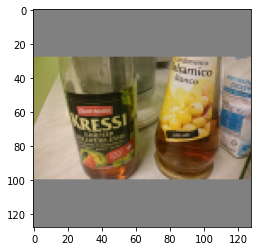

In [ ]:
plt.imshow((tf.squeeze(train_images[3])),cmap="gray")

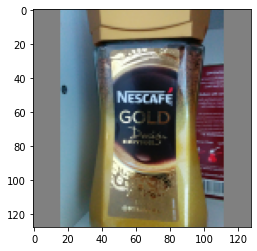

In [ ]:
plt.imshow(train_images[0])

In [ ]:
print(train_images.shape)
print(test_images.shape)

(4699, 128, 128, 3)
(248, 128, 128, 3)


In [ ]:
train_size =4699
batch_size = 32
test_size = 248

## Use *tf.data* to batch and shuffle the data

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [ ]:
train_dataset

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=4, strides=(2, 2), activation='relu'),
         tf.keras.layers.Conv2D(
                filters=512, kernel_size=4, strides=(2, 2), activation='relu'),
            
        #   tf.keras.layers.Conv2D(
        #         filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
          tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=4, strides=2, padding='same',
                activation='relu'),
          # tf.keras.layers.Conv2DTranspose(
          #       filters=128, kernel_size=3, strides=2, padding='same',
          #       activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=4, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  # reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(
  #   layers.Flatten()(x_logit), scale_identity_multiplier=0.05).log_prob(layers.Flatten()(x)))
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  # print( reconstruction_term)
  logpx_z = -tf.reduce_sum( cross_ent)
  # print(logpx_z) #Tensor("Neg:0", shape=(), dtype=float32)
  logpz = log_normal_pdf(z, 0., 0.)
  # print(logpz) 
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean( logpx_z  + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [ ]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim =512
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i],cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  

Epoch: 10, Test set ELBO: -874398.25, time elapse for current epoch: 33.414143800735474


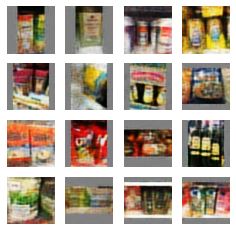

In [108]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [97]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

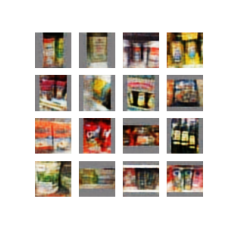

In [98]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [99]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


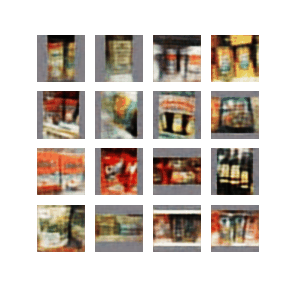

In [100]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

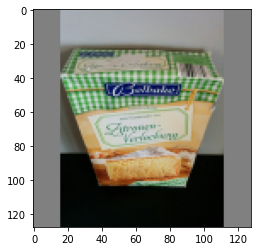

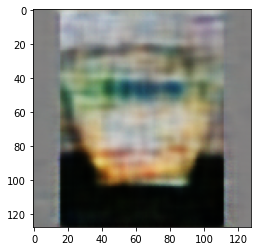

In [109]:
total_ssim=64
test_ssim = test_images[0:total_ssim, :, :, :]
mean, logvar = model.encode(test_ssim)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)
plt.imshow(test_ssim[0],cmap='gray')
plt.show()
plt.imshow(predictions[0],cmap='gray')


In [138]:
from skimage.measure import compare_ssim
score_sum=0
for i in range(0,total_ssim):
  (score, diff) = compare_ssim(cv2.cvtColor(np.array(test_ssim[i]), cv2.COLOR_BGR2GRAY), cv2.cvtColor(np.array(predictions[i]), cv2.COLOR_RGB2GRAY), full=True,multichannel=True)
  # diff = (diff * 255).astype("uint8")
  score_sum+=score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


In [139]:
score_sum/total_ssim

0.7039635916496135

In [118]:
mse=0
for i in range(0,total_ssim):
  Y = np.square(np.subtract(np.array(test_ssim[i]),np.array(predictions[i]))).mean()
  mse+=Y
  

In [119]:
mse/total_ssim

0.010724178489908809

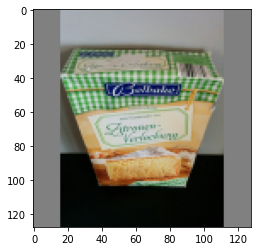

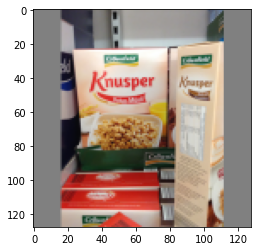

In [132]:
plt.imshow(test_ssim[0],cmap='gray')
plt.show()
plt.imshow(test_ssim[1],cmap='gray')

In [ ]:
train_images[0:16].shape

(16, 128, 128, 3)

In [147]:
score,_=compare_ssim(np.array(test_ssim[0]),np.array(test_ssim[1]), full=True,multichannel=True)
print(score)

0.28402303115617133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


In [146]:
np.square(np.subtract(np.array(test_ssim[0]),np.array(test_ssim[1]))).mean()

0.11637274

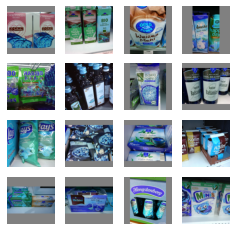

In [ ]:
 fig = plt.figure(figsize=(4, 4))

for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_sample[i,:,:,:],cmap='gray')
    plt.axis('off')

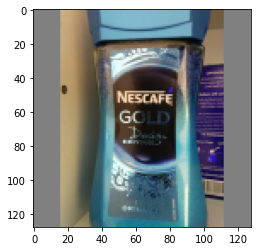

In [ ]:
plt.imshow(train_images[0])

In [ ]:
testz=np.random.rand(16,512)

In [ ]:
testz=tf.convert_to_tensor(testz)

In [ ]:
testz.shape

TensorShape([16, 512])

In [ ]:
z.shape

TensorShape([16, 512])

(-0.5, 127.5, 127.5, -0.5)

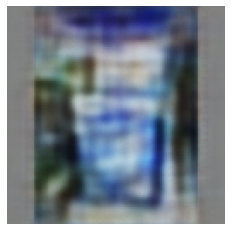

In [ ]:
plt.imshow(predictions[6],cmap='gray')
plt.axis('off')

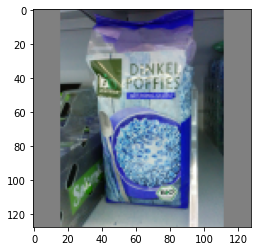

In [ ]:
plt.imshow(test_sample[6],cmap='gray')